<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
!pip install japanize-matplotlib

In [271]:
import pathlib
import re
from urllib.parse import urljoin

In [272]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [273]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [274]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [275]:
import pandas as pd

In [276]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [277]:
df_kanja.shape

(1536, 10)

In [278]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      1534 non-null   Int64 
 1   発表日     1534 non-null   object
 2   年代      1534 non-null   object
 3   性別      1534 non-null   object
 4   管轄      1534 non-null   object
 5   居住地     1534 non-null   object
 6   職業      1533 non-null   object
 7   発症日     1534 non-null   object
 8   渡航歴     1534 non-null   object
 9   備考欄     1533 non-null   object
dtypes: Int64(1), object(9)
memory usage: 121.6+ KB


In [279]:
df_kanja.count()

番号     1534
発表日    1534
年代     1534
性別     1534
管轄     1534
居住地    1534
職業     1533
発症日    1534
渡航歴    1534
備考欄    1533
dtype: int64

# 前処理

In [280]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [281]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [282]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [283]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [284]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja.drop(738, inplace=True)

In [285]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [286]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [287]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

# 年代確認

## 年代別グラフ

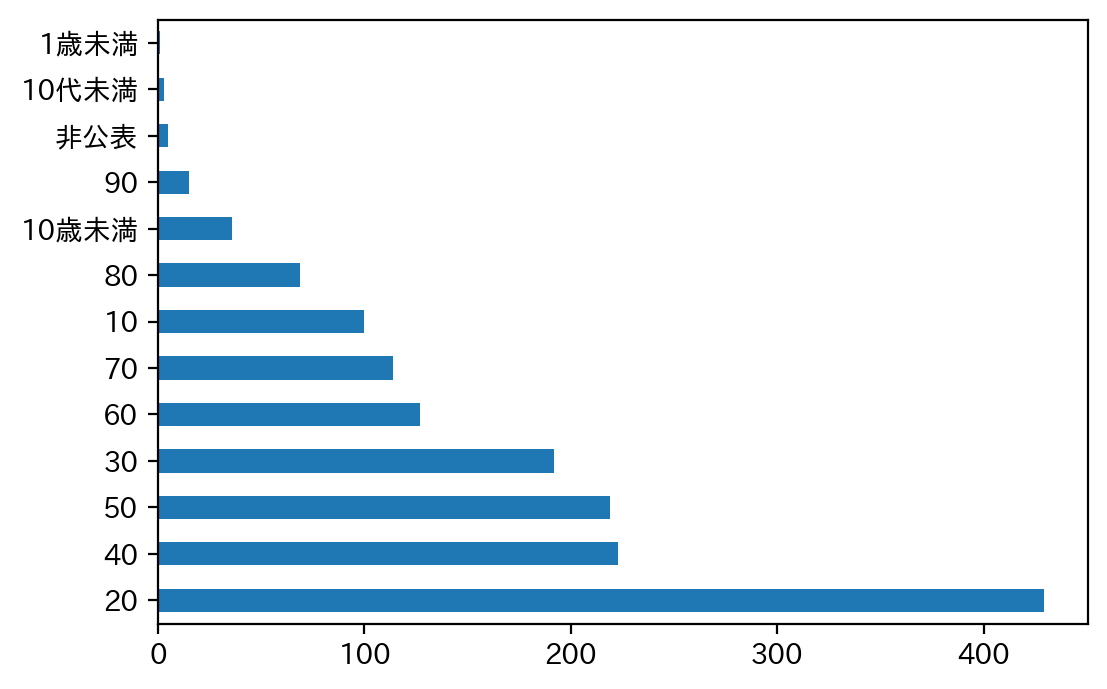

In [288]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [289]:
df_kanja["年代"].value_counts()

20       429
40       223
50       219
30       192
60       127
70       114
10       100
80        69
10歳未満     36
90        15
非公表        5
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

In [290]:
df_kanja[df_kanja["年代"] == "10代未満"]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり


# 性別確認

## 性別別グラフ

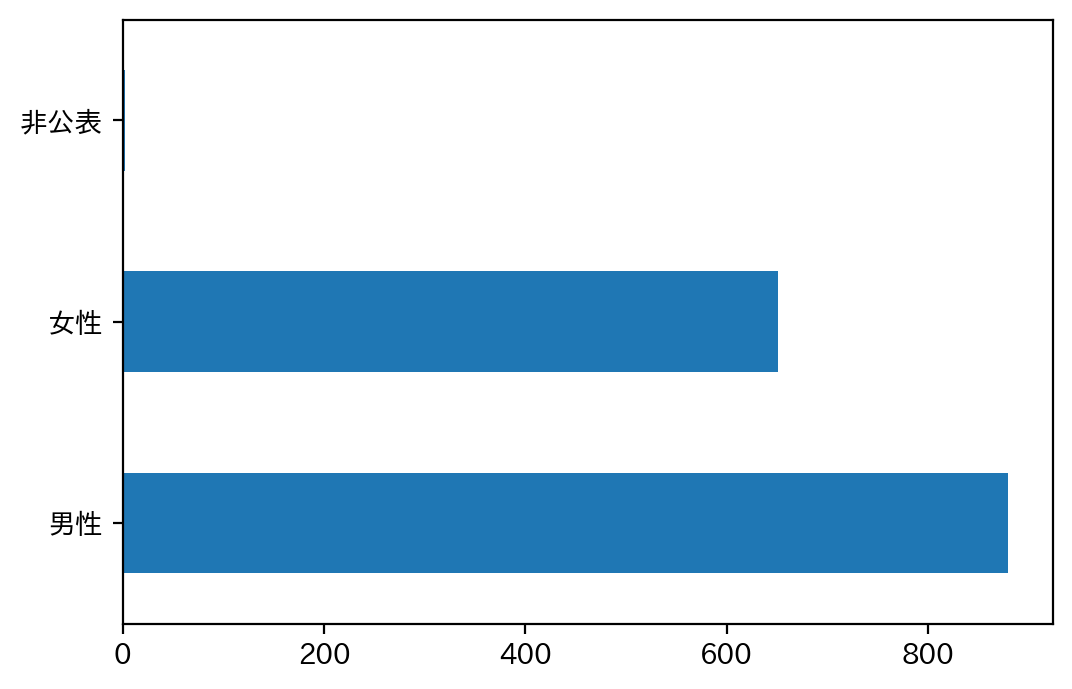

In [291]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [292]:
df_kanja["性別"].value_counts()

男性     880
女性     651
非公表      2
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

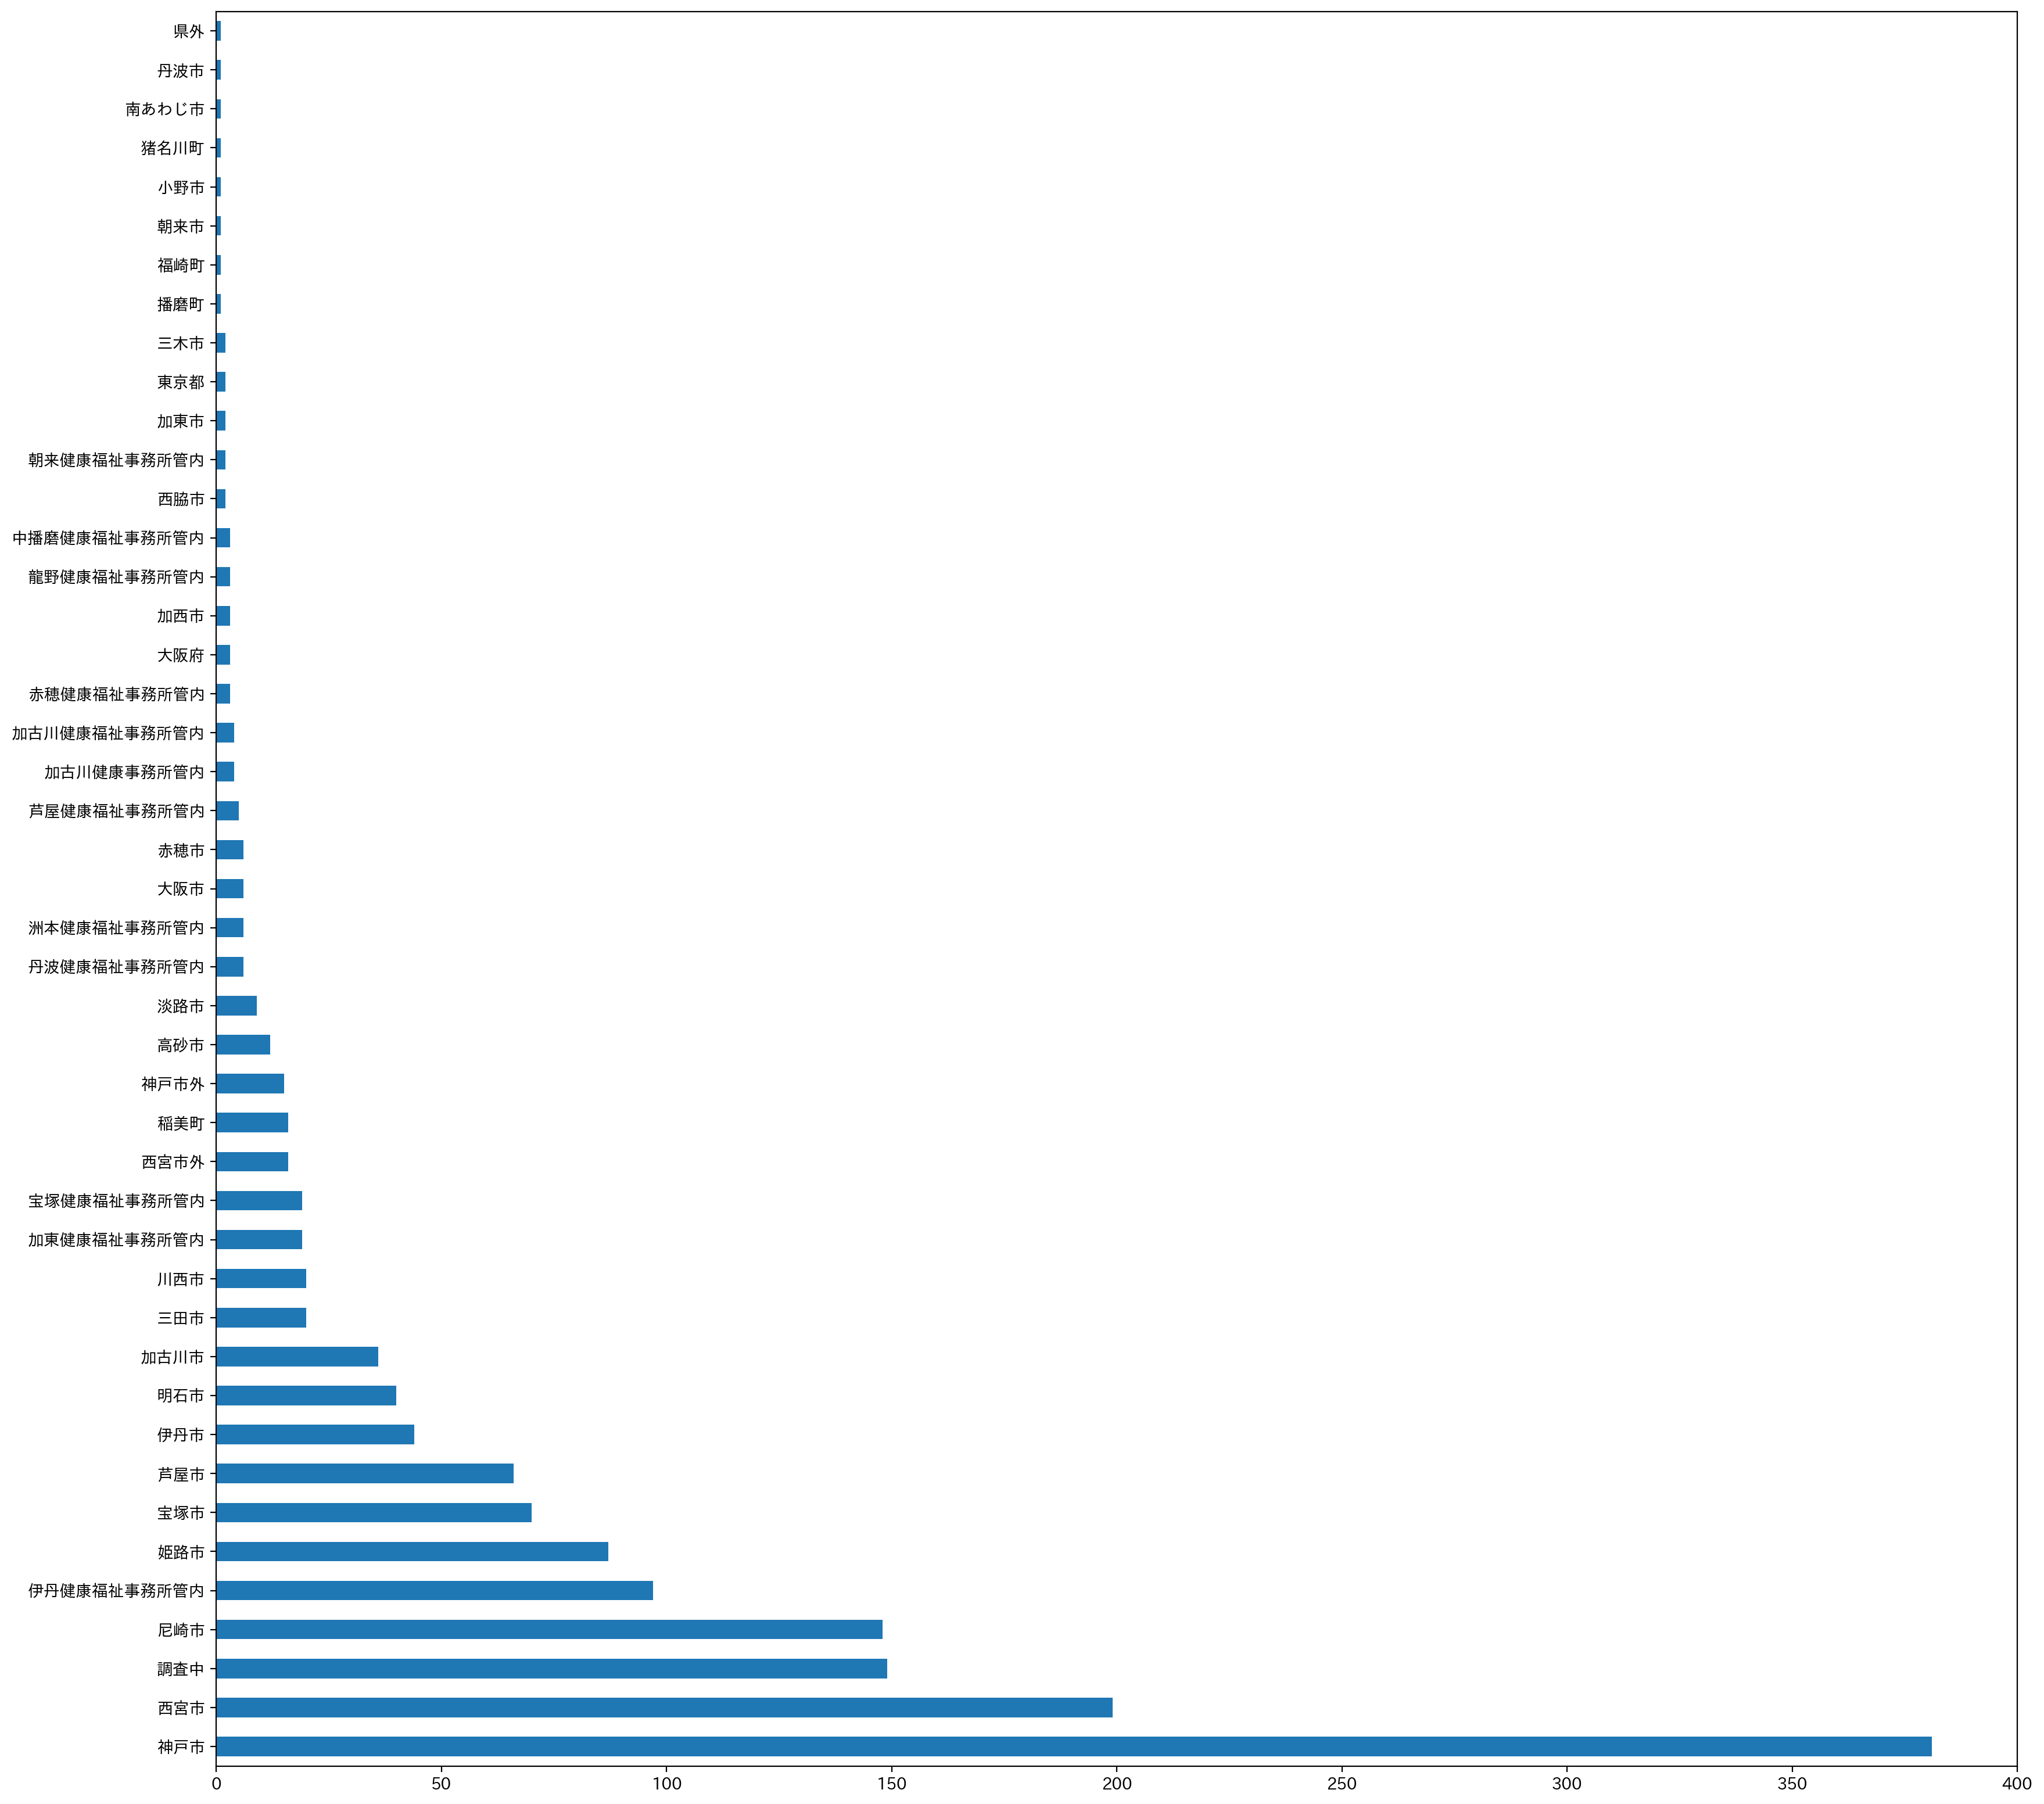

In [293]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [294]:
df_kanja["居住地"].value_counts()

神戸市             381
西宮市             199
調査中             149
尼崎市             148
伊丹健康福祉事務所管内      97
姫路市              87
宝塚市              70
芦屋市              66
伊丹市              44
明石市              40
加古川市             36
三田市              20
川西市              20
加東健康福祉事務所管内      19
宝塚健康福祉事務所管内      19
西宮市外             16
稲美町              16
神戸市外             15
高砂市              12
淡路市               9
丹波健康福祉事務所管内       6
洲本健康福祉事務所管内       6
大阪市               6
赤穂市               6
芦屋健康福祉事務所管内       5
加古川健康事務所管内        4
加古川健康福祉事務所管内      4
赤穂健康福祉事務所管内       3
大阪府               3
加西市               3
龍野健康福祉事務所管内       3
中播磨健康福祉事務所管内      3
西脇市               2
朝来健康福祉事務所管内       2
加東市               2
東京都               2
三木市               2
播磨町               1
福崎町               1
朝来市               1
小野市               1
猪名川町              1
南あわじ市             1
丹波市               1
県外                1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

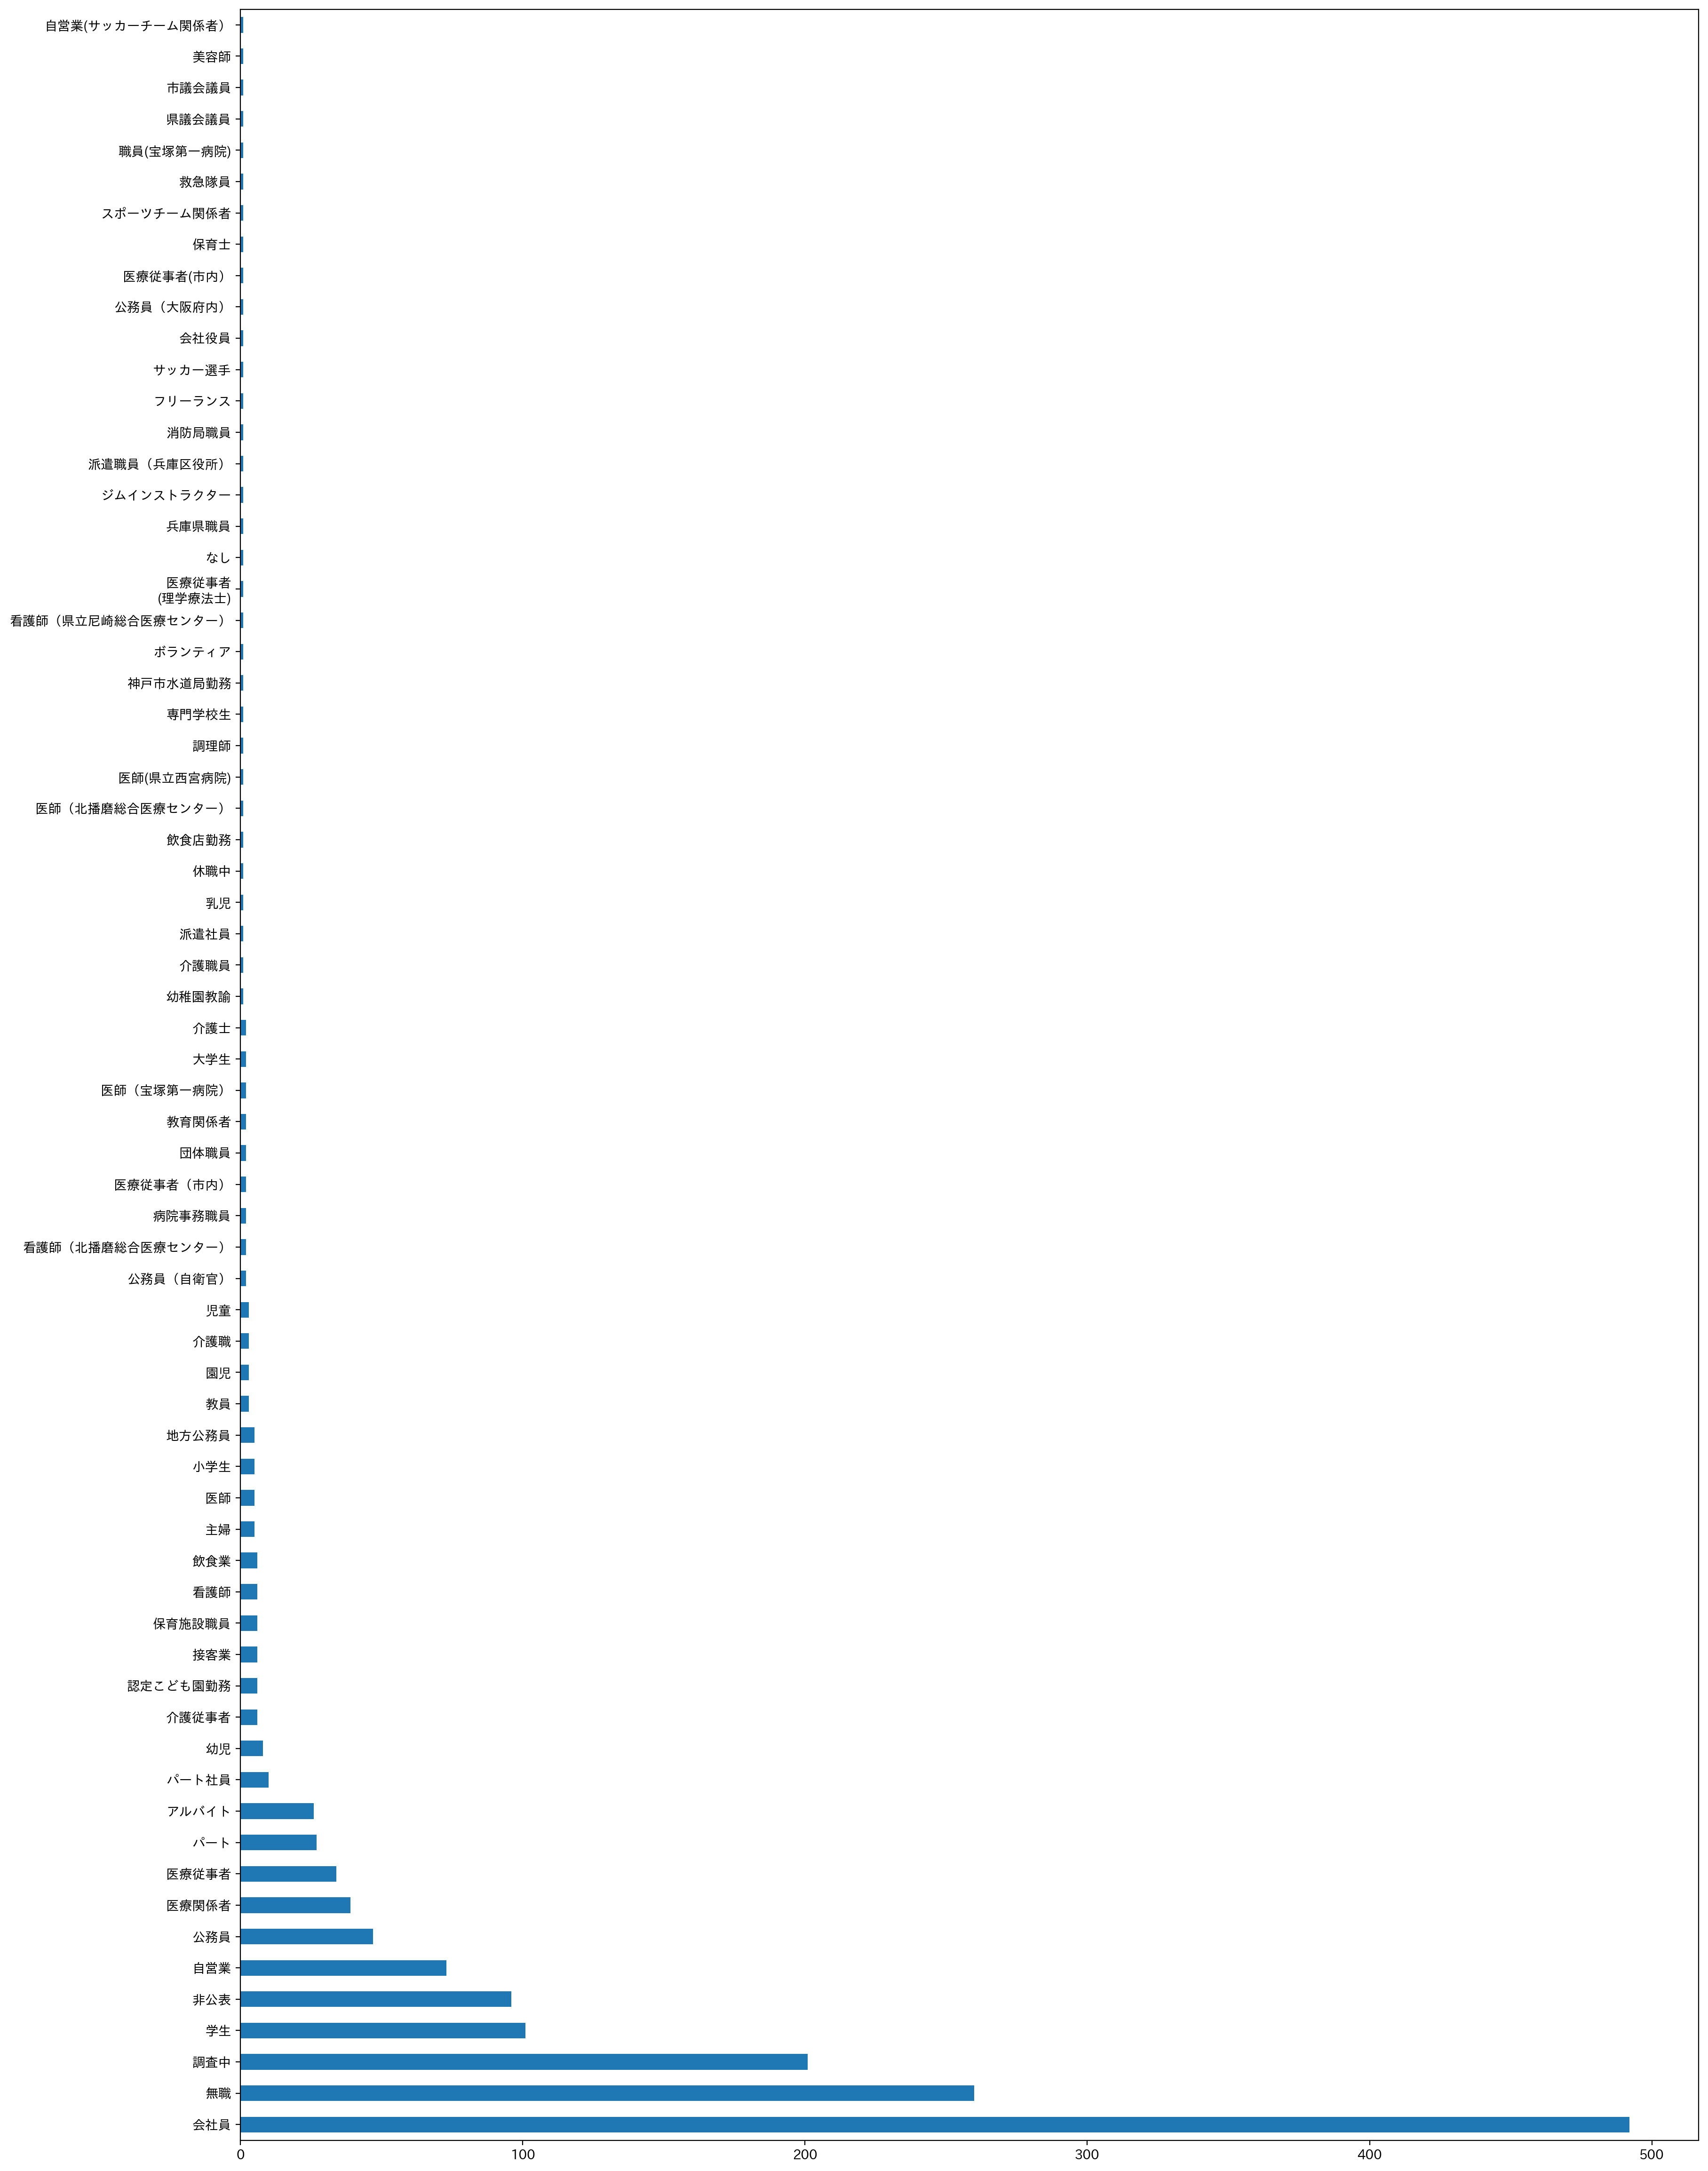

In [295]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [296]:
df_kanja["職業"].value_counts()

会社員                492
無職                 260
調査中                201
学生                 101
非公表                 96
                  ... 
職員(宝塚第一病院)           1
県議会議員                1
市議会議員                1
美容師                  1
自営業(サッカーチーム関係者）      1
Name: 職業, Length: 68, dtype: int64

# 管轄確認

## 管轄別グラフ

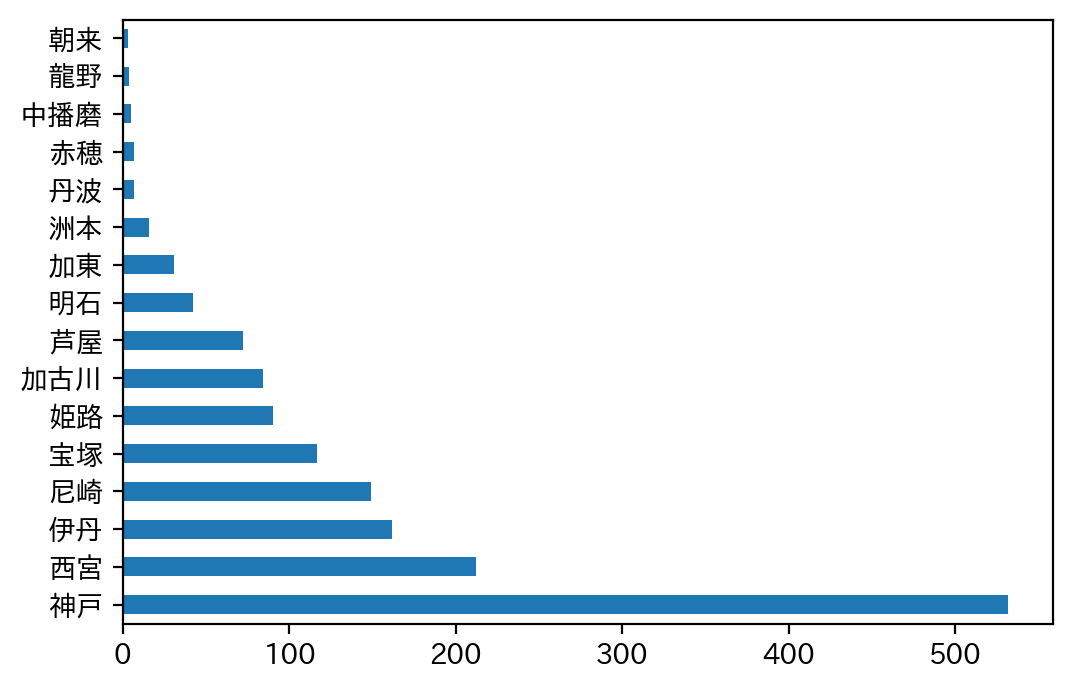

In [297]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [298]:
df_kanja["管轄"].value_counts()

神戸     532
西宮     212
伊丹     162
尼崎     149
宝塚     117
姫路      90
加古川     84
芦屋      72
明石      42
加東      31
洲本      16
丹波       7
赤穂       7
中播磨      5
龍野       4
朝来       3
Name: 管轄, dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

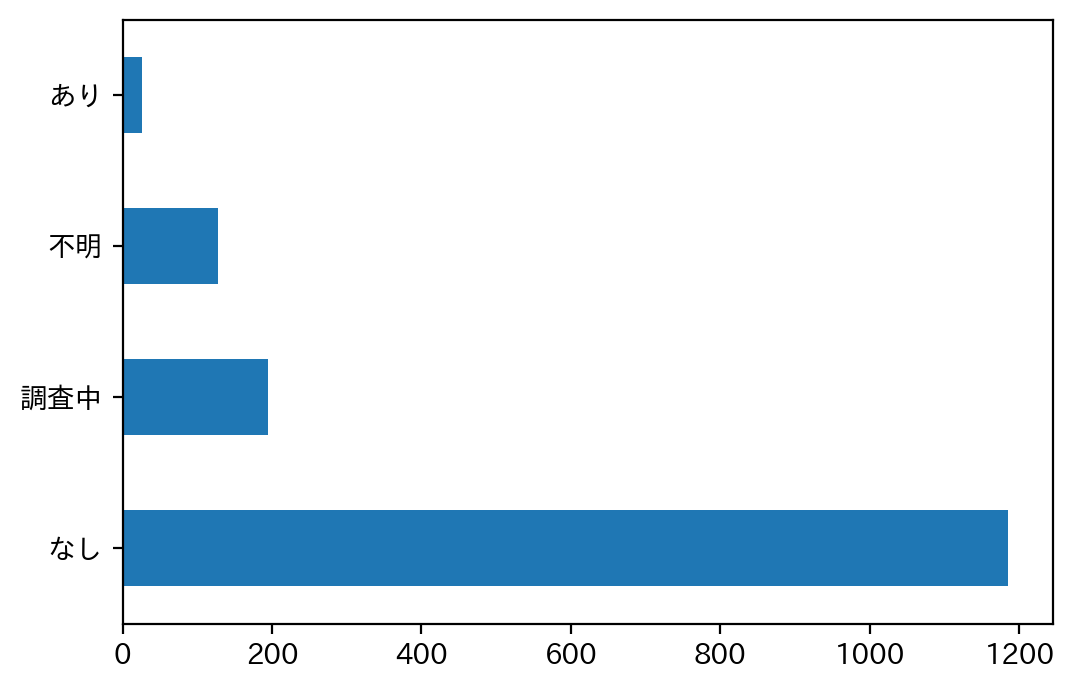

In [299]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [300]:
df_kanja["渡航歴"].value_counts()

なし     1186
調査中     194
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

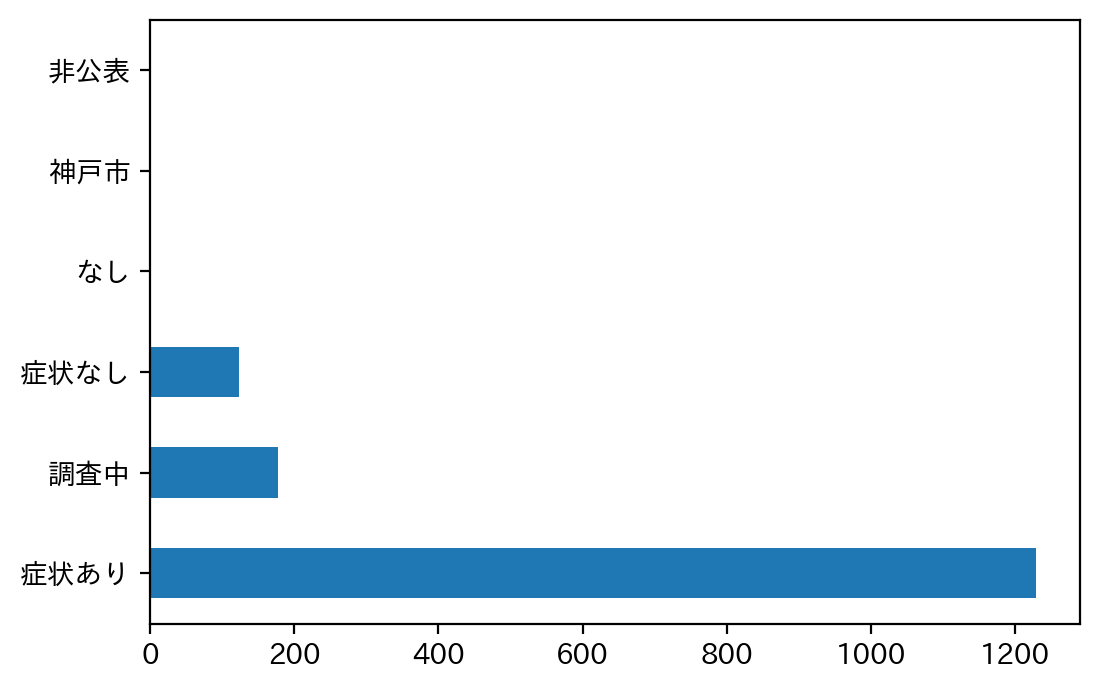

In [301]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [302]:
df_kanja["ステータス"].value_counts()

症状あり    1230
調査中      177
症状なし     123
なし         1
神戸市        1
非公表        1
Name: ステータス, dtype: int64

# 全体確認

In [303]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
1534,2020-08-07,50,女性,朝来,朝来健康福祉事務所管内,非公表,2020-08-04,なし,陽性患者の濃厚接触者,症状あり
1533,2020-08-07,30,女性,加東,加東市,非公表,2020-07-30,なし,行動歴調査中,症状あり
1532,2020-08-07,10歳未満,男性,加東,加東健康福祉事務所管内,非公表,2020-08-03,なし,陽性患者の濃厚接触者,症状あり
1531,2020-08-07,10,男性,加古川,加古川市,非公表,2020-08-03,なし,陽性患者の濃厚接触者,症状あり
1530,2020-08-07,10,女性,加古川,加古川健康福祉事務所管内,非公表,2020-08-03,なし,行動歴調査中,症状あり
...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり


# ファイル保存

In [304]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [305]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [306]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# ダウンロード

In [307]:
from google.colab import files

In [308]:
files.download(f"陽性者一覧（年齢別）_{dt_now}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PCR

In [309]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [310]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [311]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-08-03,434,132,263,39,27
2020-08-04,607,360,224,23,32
2020-08-05,775,347,392,36,52


In [312]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [313]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [314]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [315]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [316]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [317]:
df_yousei = df_yousei.fillna(0).astype(int)

In [318]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [319]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [320]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [321]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 年代

In [322]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, 90, "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
637,2020-04-28,1歳未満,男性,伊丹,川西市,乳児,2020-04-15,なし,No.635の子,症状あり
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり


### 居住地

In [323]:
nlist = df_kanja.loc[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "事務所管内")) & ~(df_kanja["居住地"] == "調査中"), "居住地"].unique()
df_kanja[df_kanja["居住地"].isin(nlist)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [324]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市


### 渡航歴

In [325]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [326]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [327]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [328]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 累計前日差チェック

In [329]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [330]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [331]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [332]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [333]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
